In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.rc('figure', figsize=(10,15))
plt.rc('font', size=14)
plt.style.use('dark_background')
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background

In [2]:
import quflow as qf

# Generate random vorticity and plot it

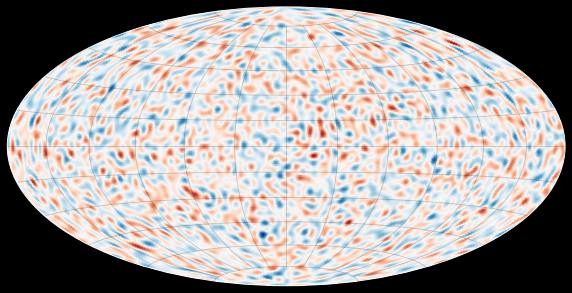

In [3]:
W = qf.shr2mat(np.random.randn(64**2), N=512)
qf.plot(W,projection='hammer', cmap='RdBu')

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function
(related to $\omega$ via Poisson's equation).
The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix
$W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

## Create initial conditions

In [4]:
N = 128 # Size of matrices

In [5]:
omegar = np.array([-1.94289029e-16,  9.34389008e-15,  1.68615122e-15, -1.59309186e-15,
                    4.18294664e-01,  5.04879629e-01,  2.05858273e-01, -6.60776951e-01,
                    6.78180820e-01, -1.01935097e-01,  2.47658404e-01,  4.13107476e-01,
                    7.95673082e-02, -1.03883724e+00, -4.76852974e-01, -6.03026919e-01,
                   -2.68486178e-01, -1.47245426e-01, -5.41379946e-01, -7.27999391e-01,
                   -3.75207725e-02, -1.44058680e+00, -1.16117652e+00,  5.68201184e-01,
                    5.08163712e-02,  1.11902515e-01,  8.86920379e-01,  4.99418111e-01,
                   -1.48839722e-01, -3.61772325e-02, -2.97263898e-01,  4.94654879e-01,
                   -6.32478266e-01,  5.63515676e-02,  1.91048517e-01,  7.25260028e-01,
                    3.75714435e-01,  5.82612449e-01, -6.40261374e-01, -1.32589452e+00,
                    5.23797607e-01, -3.55600726e-01,  4.57633735e-01, -1.30008266e-01,
                    4.92011373e-01,  6.49726166e-01, -4.12497032e-01,  1.66305782e+00,
                   -7.84263691e-01, -7.50191831e-02, -2.82536547e-01,  9.77878954e-02,
                   -8.76951809e-01,  9.06721330e-02, -3.66159831e-02,  1.29758889e+00,
                   -2.23747252e-01, -3.43399134e-01,  1.09170204e-01,  1.40505556e-02,
                    1.14392871e+00,  1.39062889e-01,  8.28874065e-04, -3.40094316e-01,
                    1.16377075e+00,  1.60273703e-01,  1.06793866e+00,  1.36358591e-01,
                   -1.21668436e-01, -9.24004606e-02, -6.96029709e-01,  7.63455927e-01,
                    5.38242429e-01,  1.15031413e+00, -1.63548693e-01, -5.89147388e-02,
                   -3.23008105e-01, -6.97439871e-01, -6.12100120e-01, -1.68078253e+00,
                   -4.98627578e-01,  1.01844798e+00,  6.28096588e-02,  9.68062582e-01,
                   -1.22622918e-01,  1.14519931e+00,  5.98794888e-01, -1.02654169e+00,
                   -1.15832511e+00, -4.94097705e-02,  5.05476698e-01, -2.16757310e-01,
                    2.64943343e-01, -3.53073342e-01, -2.51501415e-01,  2.50421740e-01,
                    3.27569622e-01,  5.93631160e-01,  1.07535561e+00, -1.77619828e-01,
                   -5.27919934e-01, -4.94415346e-01, -1.80494298e-01, -4.55706656e-01,
                    1.09265186e-01, -7.30372640e-01, -3.74684646e-01, -4.07975658e-01,
                    8.52516531e-01, -6.31882404e-01,  1.30327119e-01,  6.88272649e-01,
                   -4.39038315e-01,  1.62940079e-01,  1.95443276e-01, -2.21053706e-01,
                    5.26453285e-01,  6.00394049e-01,  3.36134319e-01, -7.46320605e-01,
                   -9.77896464e-01])

# Convert to matrix representation
W0 = qf.shr2mat(omegar, N=N)

In [6]:
for NN in [256, 512, 1024, 2048, 4096]:
    print( "Estimated for N={} the simulation time relative to 512 is {:.1E}".format(NN, NN**4.5/(512**4.5)) )

Estimated for N=256 the simulation time relative to 512 is 4.4E-02
Estimated for N=512 the simulation time relative to 512 is 1.0E+00
Estimated for N=1024 the simulation time relative to 512 is 2.3E+01
Estimated for N=2048 the simulation time relative to 512 is 5.1E+02
Estimated for N=4096 the simulation time relative to 512 is 1.2E+04


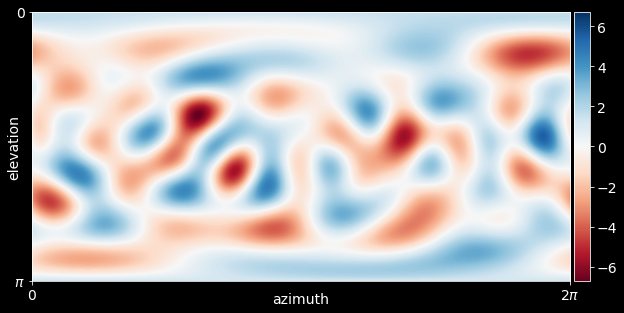

In [7]:
# Plot initial conditions
qf.plot(W0, N=256, cmap='RdBu')

## Run simulation

In [8]:
filename = 'my_quflow_simulation3.hdf5'
time = 5.0 # in second
inner_time = 0.2 # in seconds
qstepsize = 0.2 # in qtime

In [9]:
print("The physical stepsize is",qf.qtime2seconds(qstepsize, N),"seconds")

The physical stepsize is 0.0009791516697777345 seconds


In [10]:
# Callback data object
mysim = qf.QuData(filename, verbatim=True)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Run simulation
qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim)

# Flush cache data
mysim.flush()

Found data in file my_quflow_simulation3.hdf5 at qtime = 0.0.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


qtime = 40.800000000000004, time = 0.19974694063465784, output steps = 1
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 81.60000000000001, time = 0.3994938812693157, output steps = 2
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 122.4, time = 0.5992408219039735, output steps = 3
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 163.20000000000002, time = 0.7989877625386314, output steps = 4
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 204.00000000000003, time = 0.9987347031732892, output steps = 5
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 244.80000000000004, time = 1.198481643807947, output steps = 6
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 285.6, time = 1.398228584442605, output steps = 7
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 326.40000000000003, time = 1.5979755250772627, output steps = 8
Cached data saved to file my_quflow_simulation3.hdf5
qtime = 367.20000000000005, 

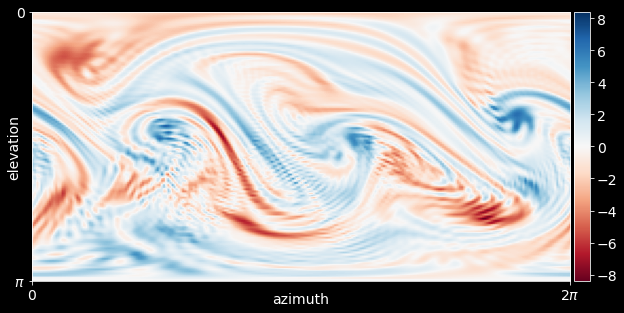

In [11]:
# Plot last state
omega = qf.load(filename)[-1]
qf.plot(omega, cmap='RdBu')

## Animate the results

In [13]:
qf.create_animation("my_quflow_animation.mp4", qf.load(filename))

Writing file my_quflow_animation.mp4
__________________________
**************************


## Compute canonical decomposition

In [14]:
[Ws,Wr]=qf.scale_decomposition(W)
P = qf.solve_poisson(W)

array([[<matplotlib.image.AxesImage object at 0x10db773a0>],
       [<matplotlib.image.AxesImage object at 0x10e298d30>]], dtype=object)

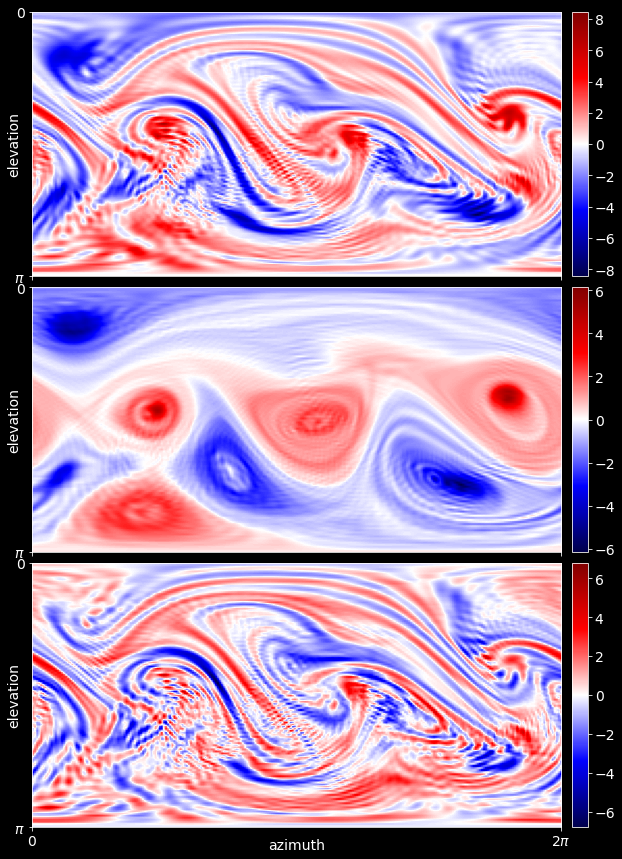

In [15]:
qf.plot([[W],[Ws],[Wr]])